In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import randint, uniform

# Sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor  # For regression
from sklearn.ensemble import RandomForestClassifier  # For classification
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neighbors import KNeighborsRegressor

pd.options.display.float_format = '{:.2f}'.format

## IMPORT & EXPLORE

In [2]:
# Let's laod saved np.array converted images 

lung_scan_cases = np.load(r"C:\Users\User\Desktop\lung_tumor_project\ct_scans\scan_arrays\lung_tumor_scan_cases.npz")['scan_array']

lung_scan_cases_labels = np.load(r"C:\Users\User\Desktop\lung_tumor_project\ct_scans\scan_arrays\lung_tumor_scan_cases.npz")['labels']


In [3]:
lung_scan_cases.shape

(4159, 224, 224, 1)

Shape of this array tells us that : We have 4159 images with 224x224 resolution which is in grayscale, 

In [4]:
pd.Series(lung_scan_cases_labels).value_counts(normalize = True)

2   0.39
0   0.33
1   0.29
Name: proportion, dtype: float64

And we also dealing with near balanced data , as all classes have near equal number of presentations in the "lung_scan_cases_labels" array.

## CLEAN & PREPARE

#### PREPARE DATA FOR MODEL BUILDING

before we split data into subsets , i suggest we deal with loss functions for our task. As labels in this specific task are integer encoded , we could use availablle Sparse Categorical cross-entropy from tensorflow , but in case we are dealing with task where fasle negative is very dangerous or at least more important to avoid than false positive , we need to write our own loss function.

In [5]:
import tensorflow as tf
from tensorflow.keras import losses

In [6]:
class WeightedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    def __init__(self, weight_factor=2.0, **kwargs):
        """
        Custom loss function that applies a higher penalty for false negatives 
        in classes 1 and 2.

        Parameters:
        - weight_factor: Float, multiplier for FN penalty on classes 1 and 2.
        """
        super().__init__(**kwargs)
        self.base_loss = losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
        self.weight_factor = weight_factor

    def call(self, y_true, y_pred):
        # Compute base loss per sample
        base_loss = self.base_loss(y_true, y_pred)

        # Convert true labels to integer tensor
        y_true = tf.cast(y_true, tf.int32)

        # Get predicted class (argmax over softmax probabilities)
        y_pred_class = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

        # Identify false negatives (y_true is 1 or 2 but was misclassified)
        fn_mask = tf.logical_and(tf.logical_or(tf.equal(y_true, 1), tf.equal(y_true, 2)), 
                                 tf.not_equal(y_true, y_pred_class))
        fn_mask = tf.cast(fn_mask, tf.float32)

        # Increase loss only for false negatives in classes 1 and 2
        weighted_loss = base_loss * (1 + fn_mask * (self.weight_factor - 1))

        return tf.reduce_mean(weighted_loss)


In [7]:
# Now , we can split data 

lung_scan_cases_train , lung_scan_cases_test , lung_scan_cases_labels_train , lung_scan_cases_labels_test = train_test_split(
    lung_scan_cases ,
    lung_scan_cases_labels ,
    train_size = 0.85 ,
    stratify = lung_scan_cases_labels ,
    random_state = 42
)


In [8]:
# and let's also obtain validation set 

lung_scan_cases_train , lung_scan_cases_validation , lung_scan_cases_labels_train , lung_scan_cases_labels_validation = train_test_split(
    lung_scan_cases_train ,
    lung_scan_cases_labels_train ,
    train_size = 0.75 ,
    stratify = lung_scan_cases_labels_train ,
    random_state = 42
)


## MODEL BUILDING

#### BUILDING STRUCTURE

In [9]:
from tensorflow.keras import models , layers , optimizers , regularizers , callbacks

In [40]:
lung_scan_cases_sequential_neural_net = models.Sequential( [

    layers.Conv2D( filters = 32 ,
                   kernel_size = (3,3),
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)) ,

    layers.Conv2D( filters = 64 ,
                   kernel_size = (3,3),
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)) ,

    layers.Conv2D( filters = 128 ,
                   kernel_size = (3,3),
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)) ,

    layers.Conv2D( filters = 256 ,
                   kernel_size = (3,3),
                   activation = 'relu',
                   kernel_regularizer = regularizers.l2(0.003)),
    layers.BatchNormalization(),
    layers.MaxPool2D((3,3)) ,
    
] )

In [41]:
lung_scan_cases_sequential_neural_net.add( layers.GlobalAveragePooling2D())

lung_scan_cases_sequential_neural_net.add( layers.Dense( units = 128 ,
                                                         activation = 'relu') )

lung_scan_cases_sequential_neural_net.add( layers.Dropout(rate = 0.4) )

lung_scan_cases_sequential_neural_net.add( layers.Dense( units = 3 ,
                                                         activation = 'softmax') )

In [42]:
lung_scan_cases_sequential_neural_net.build( input_shape = (None,224, 224, 1) )

In [43]:
lung_scan_cases_sequential_neural_net.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 22, 22, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,043 (1.61 MB)

 Trainable params: 422,083 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

#### COMPILE

In [44]:
lung_scan_cases_sequential_neural_net.compile( optimizer = optimizers.Adam() ,
                                               loss = WeightedSparseCategoricalCrossentropy(),
                                               metrics = ['accuracy'] )

In [45]:
lung_scan_cases_sequential_neural_net_early_stopping = callbacks.EarlyStopping( monitor = 'val_loss',
                                                                                patience = 25 ,
                                                                                restore_best_weights = True )

#### TRAIN

In [46]:
training_history = lung_scan_cases_sequential_neural_net.fit( lung_scan_cases_train ,
                                                              lung_scan_cases_labels_train ,
                                                              validation_data = [lung_scan_cases_validation,lung_scan_cases_labels_validation],
                                                              epochs = 100 ,
                                                              callbacks = lung_scan_cases_sequential_neural_net_early_stopping,
                                                              batch_size = 32 ,
                                                              verbose = 1 )

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 46s 527ms/step - accuracy: 0.5660 - loss: 2.4621 - val_accuracy: 0.3869 - val_loss: 4.3147
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 533ms/step - accuracy: 0.7584 - loss: 1.5857 - val_accuracy: 0.3869 - val_loss: 5.5723
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 43s 524ms/step - accuracy: 0.8288 - loss: 1.3713 - val_accuracy: 0.3869 - val_loss: 6.3997
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 526ms/step - accuracy: 0.8667 - loss: 1.2058 - val_accuracy: 0.3869 - val_loss: 7.0106
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step - accuracy: 0.8857 - loss: 1.1094 - val_accuracy: 0.5441 - val_loss: 2.8713
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 527ms/step - accuracy: 0.9232 - loss: 0.9475 - val_accuracy: 0.6912 - val_loss: 1.7581
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 45s 538ms/step - accuracy: 0.9310 - loss: 0.8996 - val_accuracy: 0.5554 - val_loss: 3.1478
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 44s 525ms/step - accuracy: 0.9352 - loss: 0.8461 - 

<Axes: title={'center': 'VAL ACCURACY'}>

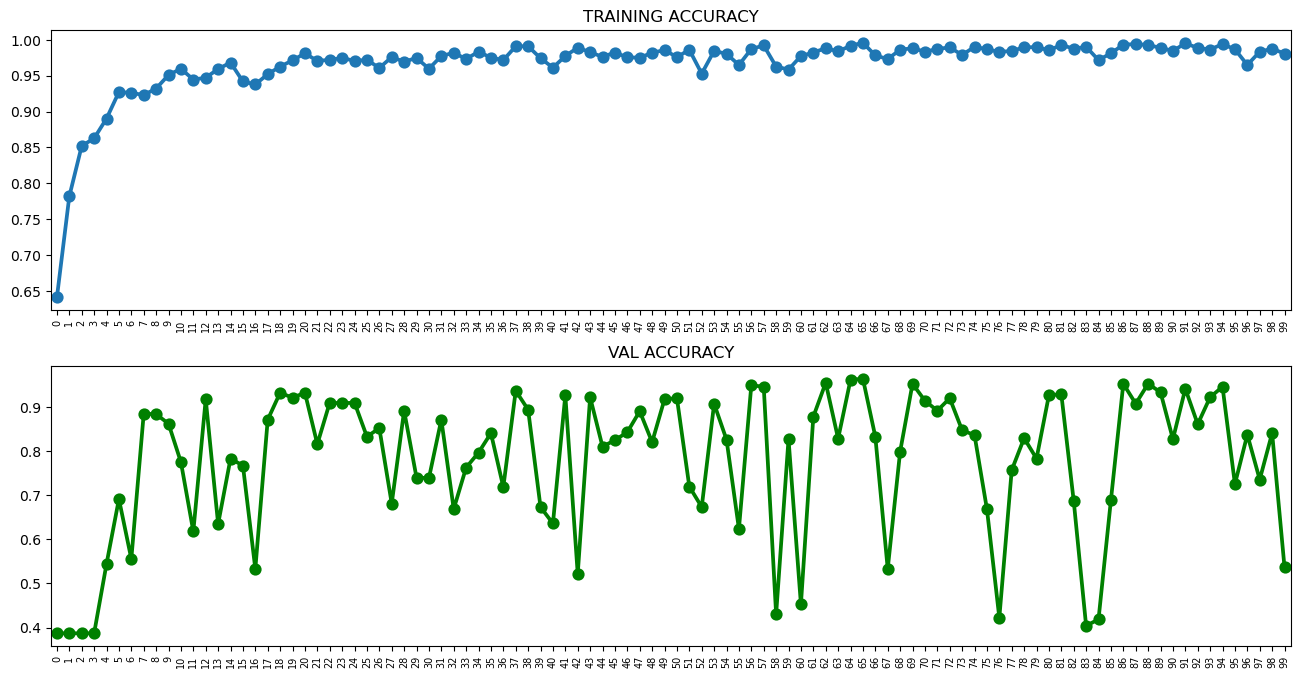

In [47]:


plt.figure(figsize = (16,8))

plt.subplot(2,1,1)

plt.title('TRAINING ACCURACY')
plt.xticks(rotation = 90,fontsize = 7)

sns.pointplot(data = training_history.history,
              x = training_history.epoch ,
              y = training_history.history['accuracy'])



plt.subplot(2,1,2)

plt.title('VAL ACCURACY')
plt.xticks(rotation = 90,fontsize = 7)

sns.pointplot(data = training_history.history,
              x = training_history.epoch ,
              y = training_history.history['val_accuracy'],
              color = 'green')




Training accuracy looks more stable than validation one , which is common case , let's evaluate model to measure it's performance on hold-out set.

#### EVALUATE

In [48]:
lung_scan_cases_sequential_neural_net.evaluate( lung_scan_cases_test , lung_scan_cases_labels_test  )

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9587 - loss: 0.3781


[0.36403536796569824, 0.9615384340286255]

In [49]:
lung_scan_cases_sequential_neural_net_predictions = np.argmax(lung_scan_cases_sequential_neural_net.predict(lung_scan_cases_test),axis = 1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


In [50]:
lung_scan_cases_sequential_neural_net_predictions_report = metrics.classification_report( lung_scan_cases_labels_test ,
                                                                                          lung_scan_cases_sequential_neural_net_predictions)

print(lung_scan_cases_sequential_neural_net_predictions_report)


              precision    recall  f1-score   support

           0       0.97      0.93      0.95       203
           1       0.96      0.95      0.95       180
           2       0.96      1.00      0.98       241

    accuracy                           0.96       624
   macro avg       0.96      0.96      0.96       624
weighted avg       0.96      0.96      0.96       624



Based on this classification report , i can say that model : has highest f1 score for class 2 , average f1 scores and accuracy are equal. 

If we remember , 2 class represent Malignant tumor which is cancerous comparing with Benign which is represented as class 1 here. As i difened earlier , in our and similar cases , false negatives must be reduced as much as possible because of well known reasons , and custom loss function helped us with that.

#### SAVE

In [51]:
# model will be saved in both , joblib and keras formats 

from joblib import dump

dump(lung_scan_cases_sequential_neural_net,"lung_scan_cases_sequential_neural_net.joblib")

lung_scan_cases_sequential_neural_net.save("lung_scan_cases_sequential_neural_net.keras")